In [1]:
from channels.ina_nygren_schneider_only_exp_with_data import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde

def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','sodium_current.i_Na','sodium_current.m_infinity_cube','sodium_current.h_infinity','membrane.V']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def pyabc_simulate(pars):
    res = simulate_model(**pars)
    return res

logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

INFO:myokit:Loading Myokit version 1.28.4


cleft_space_ion_concentrations.Na_c 120
intracellular_ion_concentrations.Na_i 70
membrane.T 297.15
cleft_space_ion_concentrations.Na_c 120
intracellular_ion_concentrations.Na_i 70
membrane.T 297.15
cleft_space_ion_concentrations.Na_c 120
intracellular_ion_concentrations.Na_i 70
membrane.T 297.15
cleft_space_ion_concentrations.Na_c 120
intracellular_ion_concentrations.Na_i 70
membrane.T 297.15
cleft_space_ion_concentrations.Na_c 120
intracellular_ion_concentrations.Na_i 70
membrane.T 297.15


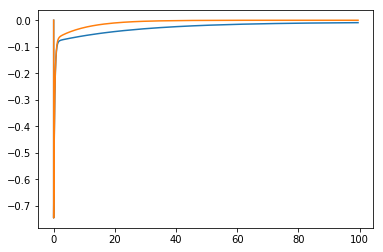

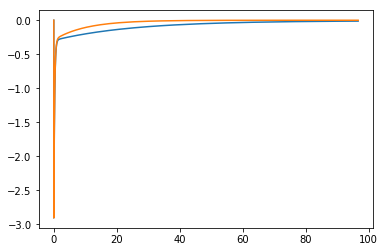

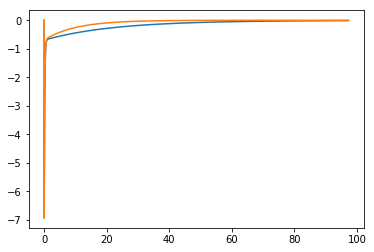

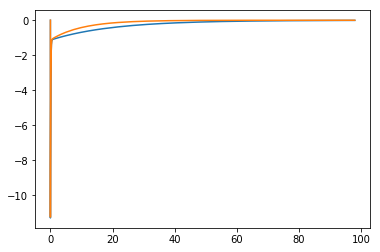

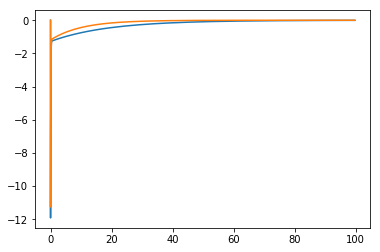

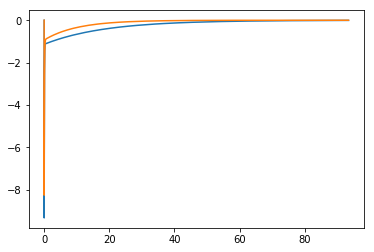

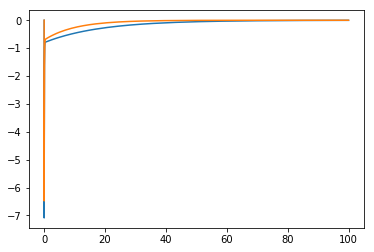

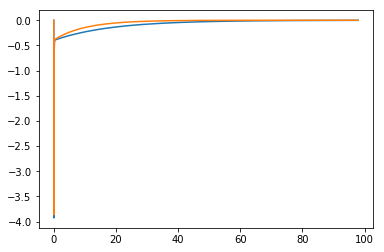

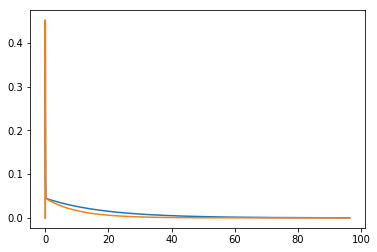

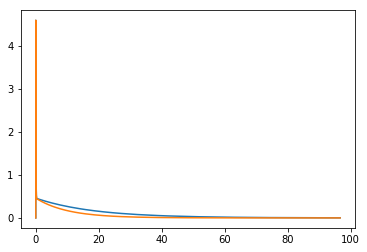

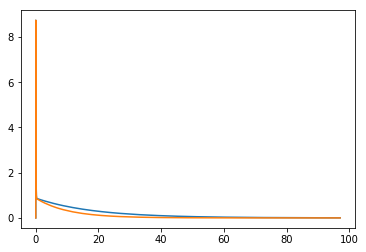

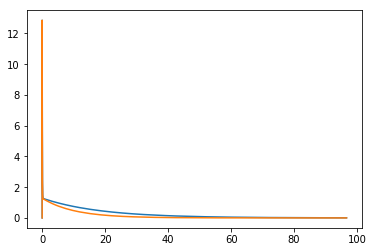

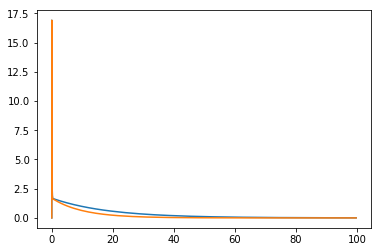

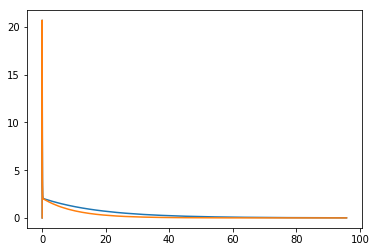

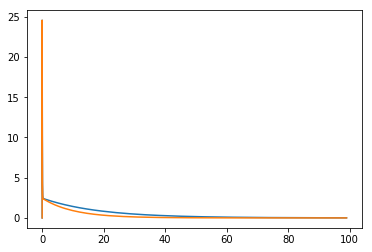

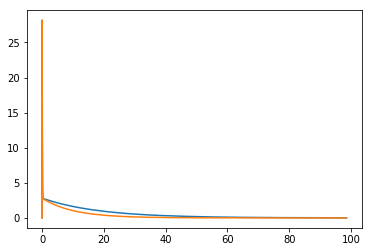

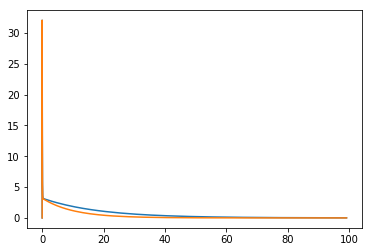

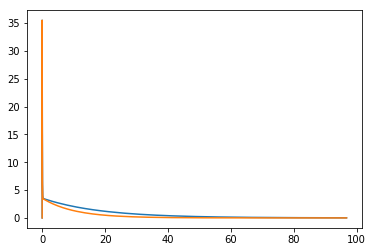

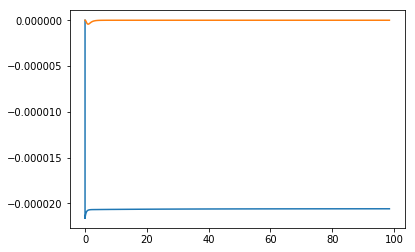

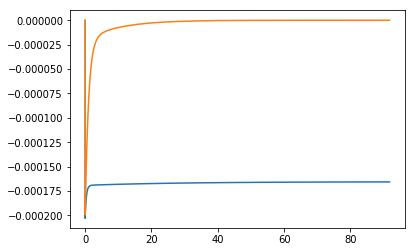

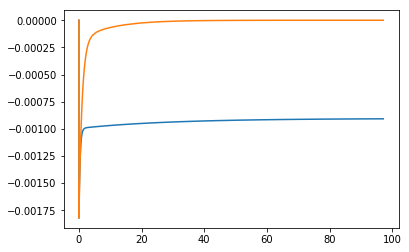

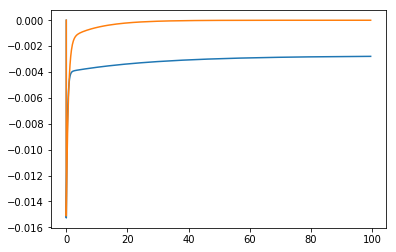

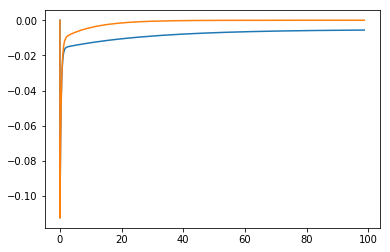

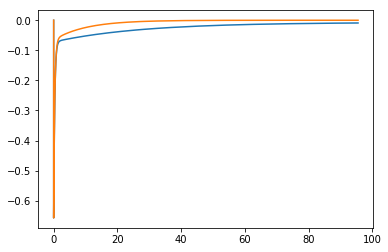

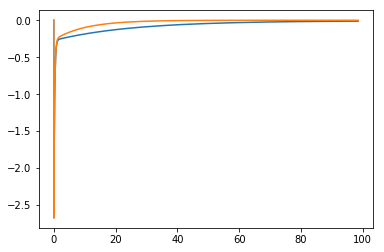

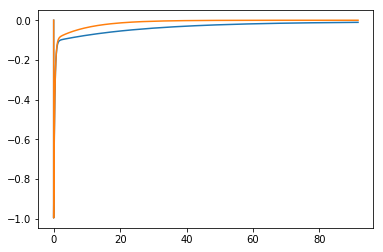

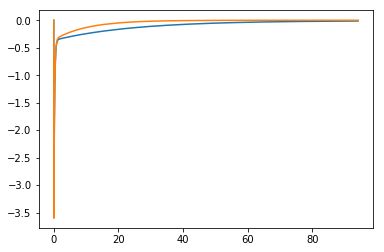

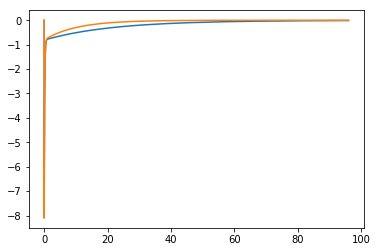

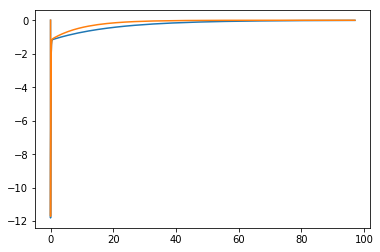

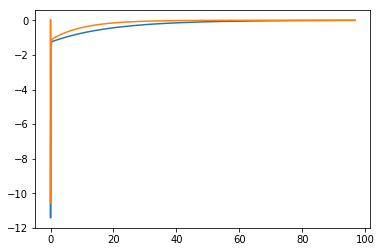

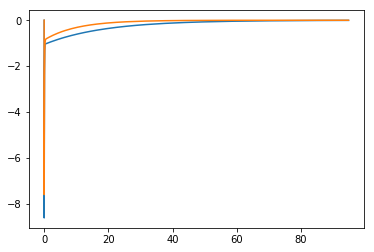

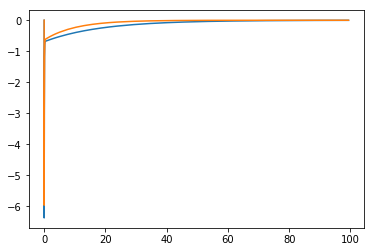

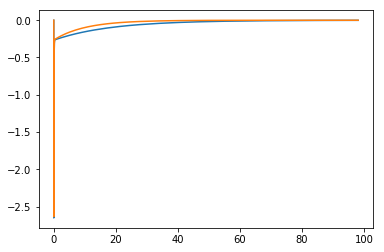

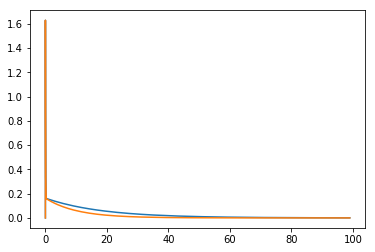

In [2]:
test = simulate_model()
ss = summary_statistics(test)

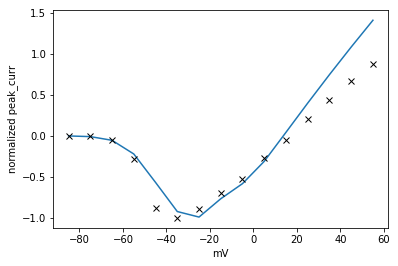

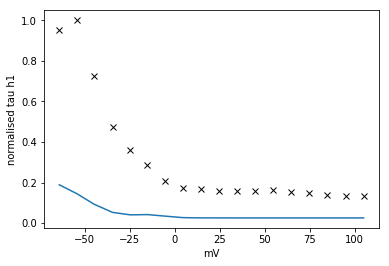

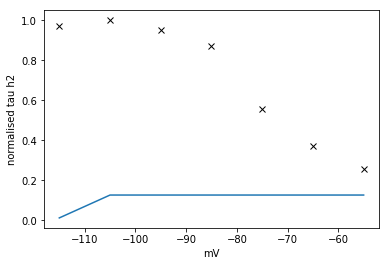

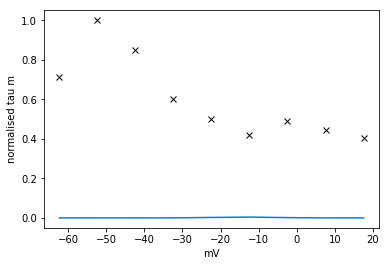

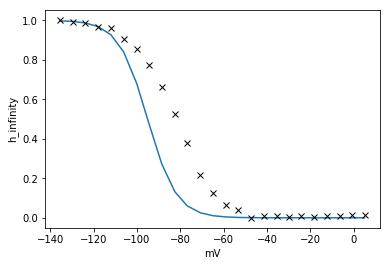

In [3]:
curr_list = (ss.items())
j = 15 # cut between theIV curve and tau_h1
k = j +18 # cut between tau_h1 and tau_h2
l = k +7 # cut between tau_h2 and tau_m
m = l + 9 #cut between tau_m and h_infinity
n = m +25 # cut between h_infinity and the recovery
x_list, y = zip(*curr_list) # unpack a list of pairs into two tuples

y_curr = list(y)[:j]


plt.plot(vsteps, y_curr,
        vsteps, peaks,'kx')
plt.xlabel('mV')
plt.ylabel('normalized peak_curr')
plt.show()

y_tauh1 = list(y)[j:k]
plt.plot(vsteps_th1, y_tauh1,
        vsteps_th1, th1,'kx')
plt.xlabel('mV')
plt.ylabel('normalised tau h1')
plt.show()

y_tauh2 = list(y)[k:l]
plt.plot(vsteps_th2, y_tauh2,
        vsteps_th2, th2,'kx')
plt.xlabel('mV')
plt.ylabel('normalised tau h2')
plt.show()

y_taum = list(y)[l:m]


plt.plot(vsteps_tm, y_taum,
        vsteps_tm, tm,'kx')
plt.xlabel('mV')
plt.ylabel('normalised tau m')
plt.show()

y_inact = list(y)[m:n]


plt.plot(vsteps_inact, y_inact,
        vsteps_inact, inact,'kx')
plt.xlabel('mV')
plt.ylabel('h_infinity')
plt.show()

## ABC RUN 

In [4]:
#          'sodium_current.r3': (0,10),
#          'sodium_current.r4': (10,20),
#          'sodium_current.r5': (80,150),
#          'sodium_current.r6': (0,0.001)}
limits = {'sodium_current.P_Na' : (5e-6,5e-5),
          'sodium_current.q1': (0,100),
          'sodium_current.q2': (0,100),
          'sodium_current.r1': (0,100),
          'sodium_current.r2': (-50,50)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# database name and path
db_name = "nygren_Na_schneider_data_5_exp.db"
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), db_name))
print(db_path)

# population size 
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

abc = ABCSMC(models=pyabc_simulate,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.01),
             population_size=ConstantPopulationSize(10000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}
abc_id = abc.new(db_path, obs)

DEBUG:ABC:ion channel weights: {'0': 1.79827624994427, '1': 1.79827624994427, '2': 1.79827624994427, '3': 1.79827624994427, '4': 1.79827624994427, '5': 1.79827624994427, '6': 1.79827624994427, '7': 1.79827624994427, '8': 1.79827624994427, '9': 1.79827624994427, '10': 1.79827624994427, '11': 1.79827624994427, '12': 1.79827624994427, '13': 1.79827624994427, '14': 1.79827624994427, '15': 0.12351978467222795, '16': 0.10945899479506276, '17': 0.08439578928343394, '18': 0.12491855464293192, '19': 0.1992044999994742, '20': 0.2541705421549913, '21': 0.2601376662364794, '22': 0.36246022175641784, '23': 0.5142256339792717, '24': 0.5527925589221665, '25': 0.737166907450258, '26': 0.6910868200017436, '27': 0.5669665835901289, '28': 0.7371663581593377, '29': 0.8190874976891135, '30': 0.7369467074230773, '31': 0.7132807340466686, '32': 0.6142140433369158, '33': 0.055069113453750235, '34': 0.06957667992042933, '35': 0.052606181707792236, '36': 0.06133214726141711, '37': 0.09411819463862302, '38': 0.1

sqlite:////tmp/nygren_Na_schneider_data_5_exp.db
Theoretical minimum population size is 32 particles


INFO:History:Start <ABCSMC(id=1, start_time=2019-07-03 02:52:48.103413, end_time=None)>


In [5]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=30, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 20416
DEBUG:Epsilon:new eps, t=1, eps=14.092451875939291
INFO:ABC:t:1 eps:14.092451875939291
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 22686
DEBUG:Epsilon:new eps, t=2, eps=11.575586758744565
INFO:ABC:t:2 eps:11.575586758744565
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 24753
DEBUG:Epsilon:new eps, t=3, eps=9.818363851918864
INFO:ABC:t:3 eps:9.818363851918864
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 26771
DEBUG:Epsilon:new eps, t=4, eps=8.548150795441614
INFO:ABC:t:4 eps:8.548150795441614
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 28831
DEBUG:Epsilon:new eps, t=5, eps=7.761989661610

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

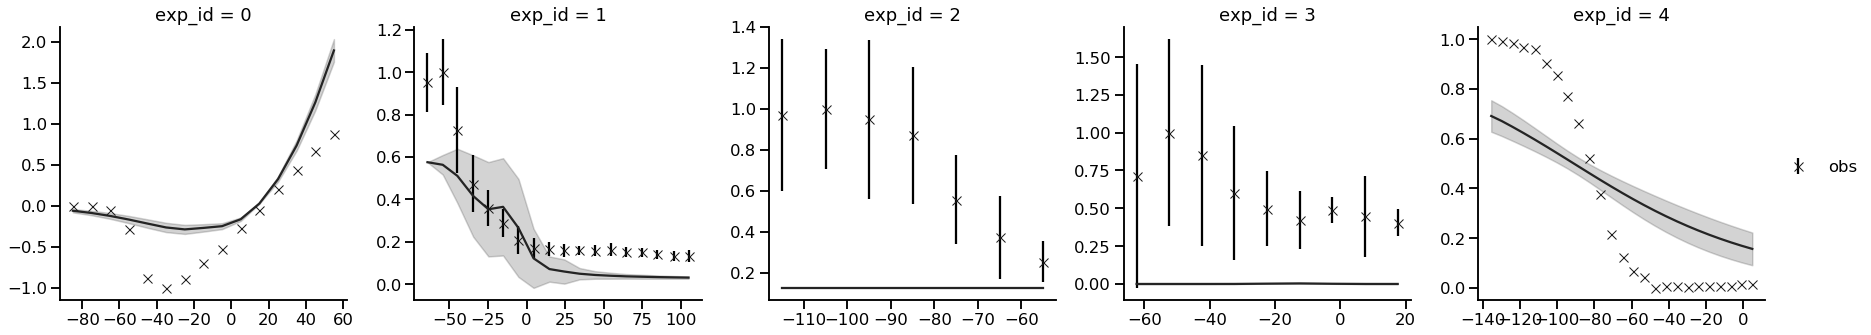

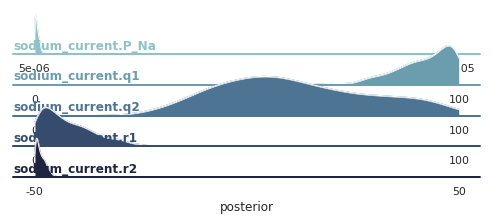

In [6]:
history = History(db_path)
history.all_runs()
history.id = 1  #nygren_Na_sakakibara_data_4_exp.db :
                #id = 1 : steady state parameters , id = 2 : tau_h (1 and 2) , id = 4 : tau_m
    
                #nygren_Na_schneider_data_2_exp.db :
                #id = 1 : steady state parameters , 
            
            
                #nygren_Na_schneider_data_5_exp.db :
                #id = 1 : steady state parameters , 
df, w = history.get_distribution(m=0)

# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
plotting_obs = observations.copy()

# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(pyabc_simulate(pars=th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp_id': plotting_obs.exp_id})
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

sns.set_context('talk')


grid1 = plot_sim_results(samples, obs=plotting_obs)
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [4]:
df.describe()

NameError: name 'df' is not defined

In [10]:
xxx = [i for i in range(-135,10,5)]
print(xxx)

[-135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5]
